<a href="https://colab.research.google.com/github/Manav716/Booking.com/blob/main/NextFlix_%E2%80%93_Personalized_and_Trending_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We’ll create 3 datasets:

Users - ID, name, country

Movies/Shows - ID, title, genre, year

Watch History - user watching which movie, when, for how long, rating, liked or not

In [14]:
!pip install faker pandas numpy


In [15]:
from faker import Faker
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta


In [16]:
fake = Faker()
Faker.seed(42)

NUM_USERS = 100000  #1 lakh users

users = []
for user_id in range(1, NUM_USERS + 1):
    users.append({
        "user_id": user_id,
        "name": fake.name(),
        "country": fake.country()
    })

df_users = pd.DataFrame(users)
df_users.head()


,user_id,name,country
0,1,Allison Hill,Czech Republic
1,2,Brian Yang,Mayotte
2,3,Javier Johnson,Cuba
3,4,Lance Hoffman,Saint Barthelemy
4,5,Kimberly Robinson,Namibia


In [7]:
genres = ['Action', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Sci-Fi', 'Horror']
NUM_MOVIES = 5000

movies = []
for movie_id in range(1, NUM_MOVIES + 1):
    movies.append({
        "movie_id": movie_id,
        "title": f"Movie {movie_id}",
        "genre": random.choice(genres),
        "year": random.randint(1980, 2023)
    })

df_movies = pd.DataFrame(movies)
df_movies.head()


,movie_id,title,genre,year
0,1,Movie 1,Action,1995
1,2,Movie 2,Romance,1984
2,3,Movie 3,Drama,1996
3,4,Movie 4,Comedy,1982
4,5,Movie 5,Comedy,2017


In [10]:
NUM_INTERACTIONS = 500000  # Half a million

watch_logs = []
for _ in range(NUM_INTERACTIONS):
    watch_logs.append({
        "user_id": random.randint(1, NUM_USERS),
        "movie_id": random.randint(1, NUM_MOVIES),
        "watch_time_minutes": random.randint(5, 180),
        "rating": random.randint(1, 5),
        "liked": random.choice([0, 1]),
        "timestamp": datetime.now() - timedelta(days=random.randint(0, 60))
    })

df_watch = pd.DataFrame(watch_logs)
df_watch.head()


,user_id,movie_id,watch_time_minutes,rating,liked,timestamp
0,40682,4196,9,3,0,2025-06-03 10:08:30.192847
1,85030,2246,167,5,0,2025-05-29 10:08:30.192861
2,61719,3861,174,5,1,2025-07-11 10:08:30.192866
3,46379,3261,7,3,0,2025-06-04 10:08:30.192871
4,51028,4063,106,4,1,2025-07-28 10:08:30.192876


***This code simulates 500,000 movie-watch interactions between users and movies, storing data like:***

which user watched which movie,

how long they watched,

how they rated it,

whether they liked it, and

when they watched it.

In [9]:
df_users.to_csv("users.csv", index=False)
df_movies.to_csv("movies.csv", index=False)
df_watch.to_csv("watch_history.csv", index=False)


Recommendation System

In [13]:
'''We’ll build two systems:'''
#1.Personalized Recommendations → Based on what each user likes.
#2.Trending Recommendations → Based on what’s popular right now.

import pandas as pd
import numpy as np

# Load CSV files
df_users = pd.read_csv("users.csv")
df_movies = pd.read_csv("movies.csv")
df_watch = pd.read_csv("watch_history.csv")

# Let's peek at the data
print("Users:\n", df_users.head(), "\n")
print("Movies:\n", df_movies.head(), "\n")
print("Watch History:\n", df_watch.head())




Users:
    user_id               name           country
0        1       Allison Hill    Czech Republic
1        2         Brian Yang           Mayotte
2        3     Javier Johnson              Cuba
3        4      Lance Hoffman  Saint Barthelemy
4        5  Kimberly Robinson           Namibia 

Movies:
    movie_id    title    genre  year
0         1  Movie 1   Action  1995
1         2  Movie 2  Romance  1984
2         3  Movie 3    Drama  1996
3         4  Movie 4   Comedy  1982
4         5  Movie 5   Comedy  2017 

Watch History:
    user_id  movie_id  watch_time_minutes  rating  liked  \
0    35917       220                  69       1      1   
1    45169      1400                 111       1      0   
2    54434      3677                  71       4      1   
3    57126      4775                 126       1      1   
4    62562       492                 137       2      1   

                    timestamp  
0  2025-07-04 10:02:14.144066  
1  2025-07-08 10:02:14.144085  
2  2025-

Trending Recommender (Popular Now)
We'll recommend movies that are being watched the most in the last 7 days.

In [17]:
from datetime import datetime, timedelta

# Convert timestamp to datetime
df_watch['timestamp'] = pd.to_datetime(df_watch['timestamp'])

# Filter for last 7 days
seven_days_ago = datetime.now() - timedelta(days=7)
recent_views = df_watch[df_watch['timestamp'] > seven_days_ago]

# Count most viewed movies
top_trending = recent_views.groupby('movie_id').size().sort_values(ascending=False).head(10)
df_trending = df_movies[df_movies['movie_id'].isin(top_trending.index)]

print("🔥 Trending Movies (Last 7 Days):\n")
print(df_trending[['title', 'genre', 'year']])


🔥 Trending Movies (Last 7 Days):

           title     genre  year
1687  Movie 1688  Thriller  1985
1723  Movie 1724     Drama  2011
1963  Movie 1964    Sci-Fi  2001
2428  Movie 2429    Comedy  1994
3620  Movie 3621     Drama  1996
4344  Movie 4345    Action  1983
4439  Movie 4440     Drama  2015
4647  Movie 4648    Action  1992
4705  Movie 4706    Horror  1981
4708  Movie 4709    Sci-Fi  2000


Personalized Recommender (User-Based Filtering)

In [27]:
#If a user liked some movies, recommend other popular movies in the same genre.

# Step 1: Join watch history with movies
df_joined = df_watch.merge(df_movies, on='movie_id')

# Step 2: Function to recommend for a specific user
def recommend_for_user(user_id, top_n=5):
    # Get movies liked by this user
    liked_movies = df_joined[(df_joined['user_id'] == user_id) & (df_joined['liked'] == 1)]

    if liked_movies.empty:
        return "User has not liked any movies yet. Showing trending instead."

    # Get user's favorite genre
    fav_genre = liked_movies['genre'].value_counts().idxmax()

    # Recommend popular movies from that genre (excluding already watched)
    watched = liked_movies['movie_id'].tolist()
    genre_movies = df_movies[(df_movies['genre'] == fav_genre) & (~df_movies['movie_id'].isin(watched))]

    # Rank by overall popularity
    pop_in_genre = df_watch[df_watch['movie_id'].isin(genre_movies['movie_id'])] \
                        .groupby('movie_id').size().sort_values(ascending=False).head(top_n)

    recs = df_movies[df_movies['movie_id'].isin(pop_in_genre.index)]
    return recs[['title', 'genre', 'year']]

# 🔍 Example: Recommendations for user 123
'''recommend_for_user(123)'''

# Ask user to input a user ID
user_input = int(input("Enter a user ID to get recommendations: "))

# Call the recommendation function with that input
recommend_for_user(user_input)



Enter a user ID to get recommendations: 78


,title,genre,year
2723,Movie 2724,Drama,1985
2826,Movie 2827,Drama,1997
3620,Movie 3621,Drama,1996
3720,Movie 3721,Drama,2009
4265,Movie 4266,Drama,2003


In [29]:
def get_recommendations(user_id):
    recs = recommend_for_user(user_id)
    if isinstance(recs, str):  # message returned
        print(recs)
        return df_trending[['title', 'genre', 'year']]
    else:
        return recs

# 🔍 Example: Cold start fallback
get_recommendations(78)


,title,genre,year
2723,Movie 2724,Drama,1985
2826,Movie 2827,Drama,1997
3620,Movie 3621,Drama,1996
3720,Movie 3721,Drama,2009
4265,Movie 4266,Drama,2003


In [ ]:
#creating a visual appearance using streamlit in vccode
#things to write in the terminal
'''
cd ~/Desktop/nextflix-project
pip install streamlit
streamlit run app.py
'''


In [38]:
def get_user_profile(user_id):
    user_data = df_watch[df_watch['user_id'] == user_id].merge(df_movies, on='movie_id')

    total_movies = int(user_data.shape[0])
    total_likes = int(user_data['liked'].sum())
    total_time = int(user_data['watch_time_minutes'].sum())
    fav_genre = user_data['genre'].value_counts().idxmax() if not user_data.empty else "N/A"

    profile = {
        "Total Movies Watched": total_movies,
        "Total Likes": total_likes,
        "Total Watch Time (mins)": total_time,
        "Favorite Genre": fav_genre
    }

    return profile, user_data

get_user_profile(1)


({'Total Movies Watched': 2,
  'Total Likes': 1,
  'Total Watch Time (mins)': 310,
  'Favorite Genre': 'Sci-Fi'},
    user_id  movie_id  watch_time_minutes  rating  liked  \
 0        1      3362                 134       1      1   
 1        1       383                 176       1      0   
 
                    timestamp       title   genre  year  
 0 2025-07-03 10:02:15.215099  Movie 3362  Sci-Fi  1980  
 1 2025-07-01 10:02:15.554707   Movie 383  Sci-Fi  2014  )

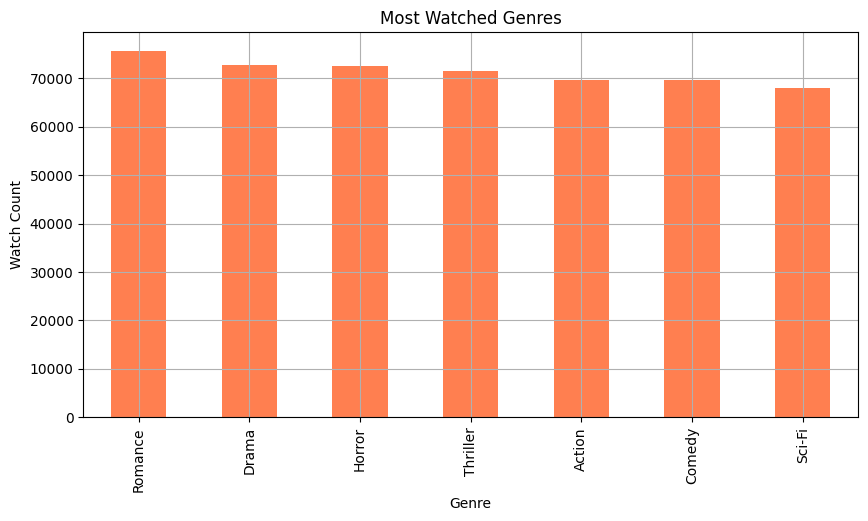

In [40]:
import matplotlib.pyplot as plt

def plot_genre_chart():
    df_joined = df_watch.merge(df_movies, on='movie_id')
    genre_counts = df_joined['genre'].value_counts()

    genre_counts.plot(kind='bar', color='coral', figsize=(10,5), title='Most Watched Genres')
    plt.xlabel("Genre")
    plt.ylabel("Watch Count")
    plt.grid(True)
    plt.show()

plot_genre_chart()


In [41]:
def get_watch_history(user_id):
    df_joined = df_watch.merge(df_movies, on='movie_id')
    user_data = df_joined[df_joined['user_id'] == user_id]
    return user_data[['title', 'genre', 'rating', 'watch_time_minutes', 'liked', 'timestamp']]

get_watch_history(1)


,title,genre,rating,watch_time_minutes,liked,timestamp
157315,Movie 3362,Sci-Fi,1,134,1,2025-07-03 10:02:15.215099
227360,Movie 383,Sci-Fi,1,176,0,2025-07-01 10:02:15.554707
